In [1]:
# Remove comment from below lines, if running on Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Remove comment from below lines, if running on Colab
DATA_DIR = "/content/drive/MyDrive/data/home-credit-default-risk/newdata"

MODEL_DIR = "/content/drive/MyDrive/output/models"

REPORT_DIR = "/content/drive/MyDrive/output/reports"

SUBMISSION_DIR = "/content/drive/MyDrive/output/submissions"

In [3]:
# temp time check - remove before submission
import datetime
begin_time = datetime.datetime.now()

# Phase 2 Data Prep

## Environment setup

The code in section 1.1 is a repeat of the code in the first EDA notebook in order to bring in the data.

In [4]:
'''# Comment below steps if running on Colab

# set the data directory
DATA_DIR = "../data/home-credit-default-risk"  # data folder will be present in the level as the code folder

# set the directory for storing model objects
MODEL_DIR = "../output/models"

# set the results folder for storing model results
REPORT_DIR = "../output/reports"

# set the submission folder
SUBMISSION_DIR = "../output/submissions"'''

'# Comment below steps if running on Colab\n\n# set the data directory\nDATA_DIR = "../data/home-credit-default-risk"  # data folder will be present in the level as the code folder\n\n# set the directory for storing model objects\nMODEL_DIR = "../output/models"\n\n# set the results folder for storing model results\nREPORT_DIR = "../output/reports"\n\n# set the submission folder\nSUBMISSION_DIR = "../output/submissions"'

In [5]:
!pip install scikit-optimize
!pip install imblearn
!pip install delayed
!pip install imbalanced-learn


     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 92kB 3.7MB/s 
     |████████████████████████████████| 81kB 5.1MB/s 


In [6]:
# data manipulation
import numpy as np
import pandas as pd 

import os
import zipfile

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# splitting
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder

# pipelines
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

# models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# tuning
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

# model evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix

# do not show warnings
import warnings
warnings.filterwarnings('ignore')

# set pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def load_data(in_path, name):
    df = pd.read_csv(in_path)
    print(f"{name}: shape is {df.shape}")
    print(df.info())
    display(df.head(5))
    return df

datasets={}  # data will be stored in a dictionary

## Data Load

In [7]:
%%time
ds_names = ("train_clean", "test_clean")

for ds_name in ds_names:
    datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

train_clean: shape is (307511, 747)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 747 entries, SK_ID_CURR to TARGET
dtypes: float64(573), int64(174)
memory usage: 1.7 GB
None


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREV_AMT_ANNUITY_min,PREV_AMT_ANNUITY_max,PREV_AMT_ANNUITY_mean,PREV_AMT_ANNUITY_count,PREV_AMT_ANNUITY_sum,PREV_AMT_APPLICATION_min,PREV_AMT_APPLICATION_max,PREV_AMT_APPLICATION_mean,PREV_AMT_DOWN_PAYMENT_min,PREV_AMT_DOWN_PAYMENT_max,PREV_AMT_DOWN_PAYMENT_count,PREV_AMT_GOODS_PRICE_min,PREV_HOUR_APPR_PROCESS_START_min,PREV_HOUR_APPR_PROCESS_START_max,PREV_HOUR_APPR_PROCESS_START_mean,PREV_NFLAG_LAST_APPL_IN_DAY_min,PREV_NFLAG_LAST_APPL_IN_DAY_max,PREV_NFLAG_LAST_APPL_IN_DAY_mean,PREV_RATE_DOWN_PAYMENT_min,PREV_RATE_DOWN_PAYMENT_max,PREV_RATE_DOWN_PAYMENT_mean,PREV_RATE_DOWN_PAYMENT_sum,PREV_RATE_INTEREST_PRIMARY_count,PREV_DAYS_DECISION_min,PREV_DAYS_DECISION_max,PREV_DAYS_DECISION_mean,PREV_DAYS_DECISION_sum,PREV_SELLERPLACE_AREA_min,PREV_SELLERPLACE_AREA_max,PREV_SELLERPLACE_AREA_mean,PREV_SELLERPLACE_AREA_sum,PREV_CNT_PAYMENT_min,PREV_CNT_PAYMENT_max,PREV_CNT_PAYMENT_mean,PREV_CNT_PAYMENT_sum,PREV_DAYS_FIRST_DRAWING_min,PREV_DAYS_FIRST_DRAWING_max,PREV_DAYS_FIRST_DRAWING_mean,PREV_DAYS_FIRST_DRAWING_count,PREV_DAYS_FIRST_DUE_max,PREV_DAYS_FIRST_DUE_mean,PREV_DAYS_LAST_DUE_1ST_VERSION_max,PREV_DAYS_LAST_DUE_1ST_VERSION_mean,PREV_DAYS_LAST_DUE_min,PREV_DAYS_LAST_DUE_max,PREV_DAYS_LAST_DUE_mean,PREV_DAYS_LAST_DUE_sum,PREV_NFLAG_INSURED_ON_APPROVAL_min,PREV_NFLAG_INSURED_ON_APPROVAL_max,PREV_NFLAG_INSURED_ON_APPROVAL_mean,PREV_NFLAG_INSURED_ON_APPROVAL_sum,PREV_POS_MONTHS_BALANCE_min_max,PREV_POS_MONTHS_BALANCE_min_mean,PREV_POS_MONTHS_BALANCE_count_min,PREV_POS_MONTHS_BALANCE_count_max,PREV_POS_MONTHS_BALANCE_count_mean,PREV_POS_MONTHS_BALANCE_count_sum,PREV_POS_MONTHS_BALANCE_sum_min,PREV_POS_MONTHS_BALANCE_sum_max,PREV_POS_MONTHS_BALANCE_sum_mean,PREV_POS_CNT_INSTALMENT_min_min,PREV_POS_CNT_INSTALMENT_min_max,PREV_POS_CNT_INSTALMENT_min_mean,PREV_POS_CNT_INSTALMENT_max_min,PREV_POS_CNT_INSTALMENT_max_max,PREV_POS_CNT_INSTALMENT_max_mean,PREV_POS_CNT_INSTALMENT_max_sum,PREV_POS_CNT_INSTALMENT_sum_min,PREV_POS_CNT_INSTALMENT_sum_max,PREV_POS_CNT_INSTALMENT_sum_mean,PREV_POS_CNT_INSTALMENT_sum_sum,PREV_POS_CNT_INSTALMENT_FUTURE_min_min,PREV_POS_CNT_INSTALMENT_FUTURE_min_max,PREV_POS_CNT_INSTALMENT_FUTURE_min_mean,PREV_POS_SK_DPD_min_max,PREV_POS_SK_DPD_min_mean,PREV_POS_SK_DPD_min_sum,PREV_POS_SK_DPD_max_min,PREV_POS_SK_DPD_max_max,PREV_POS_SK_DPD_DEF_min_max,PREV_POS_SK_DPD_DEF_min_mean,PREV_POS_SK_DPD_DEF_min_sum,PREV_POS_SK_DPD_DEF_max_min,PREV_POS_SK_DPD_DEF_max_max,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_max,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_mean,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_max,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_mean,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_sum,PREV_POS_NAME_CONTRACT_STATUS_Amortized

test_clean: shape is (48744, 746)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 746 entries, SK_ID_CURR to HAS_LIBAILITY_3
dtypes: float64(573), int64(173)
memory usage: 277.4 MB
None


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREV_AMT_ANNUITY_min,PREV_AMT_ANNUITY_max,PREV_AMT_ANNUITY_mean,PREV_AMT_ANNUITY_count,PREV_AMT_ANNUITY_sum,PREV_AMT_APPLICATION_min,PREV_AMT_APPLICATION_max,PREV_AMT_APPLICATION_mean,PREV_AMT_DOWN_PAYMENT_min,PREV_AMT_DOWN_PAYMENT_max,PREV_AMT_DOWN_PAYMENT_count,PREV_AMT_GOODS_PRICE_min,PREV_HOUR_APPR_PROCESS_START_min,PREV_HOUR_APPR_PROCESS_START_max,PREV_HOUR_APPR_PROCESS_START_mean,PREV_NFLAG_LAST_APPL_IN_DAY_min,PREV_NFLAG_LAST_APPL_IN_DAY_max,PREV_NFLAG_LAST_APPL_IN_DAY_mean,PREV_RATE_DOWN_PAYMENT_min,PREV_RATE_DOWN_PAYMENT_max,PREV_RATE_DOWN_PAYMENT_mean,PREV_RATE_DOWN_PAYMENT_sum,PREV_RATE_INTEREST_PRIMARY_count,PREV_DAYS_DECISION_min,PREV_DAYS_DECISION_max,PREV_DAYS_DECISION_mean,PREV_DAYS_DECISION_sum,PREV_SELLERPLACE_AREA_min,PREV_SELLERPLACE_AREA_max,PREV_SELLERPLACE_AREA_mean,PREV_SELLERPLACE_AREA_sum,PREV_CNT_PAYMENT_min,PREV_CNT_PAYMENT_max,PREV_CNT_PAYMENT_mean,PREV_CNT_PAYMENT_sum,PREV_DAYS_FIRST_DRAWING_min,PREV_DAYS_FIRST_DRAWING_max,PREV_DAYS_FIRST_DRAWING_mean,PREV_DAYS_FIRST_DRAWING_count,PREV_DAYS_FIRST_DUE_max,PREV_DAYS_FIRST_DUE_mean,PREV_DAYS_LAST_DUE_1ST_VERSION_max,PREV_DAYS_LAST_DUE_1ST_VERSION_mean,PREV_DAYS_LAST_DUE_min,PREV_DAYS_LAST_DUE_max,PREV_DAYS_LAST_DUE_mean,PREV_DAYS_LAST_DUE_sum,PREV_NFLAG_INSURED_ON_APPROVAL_min,PREV_NFLAG_INSURED_ON_APPROVAL_max,PREV_NFLAG_INSURED_ON_APPROVAL_mean,PREV_NFLAG_INSURED_ON_APPROVAL_sum,PREV_POS_MONTHS_BALANCE_min_max,PREV_POS_MONTHS_BALANCE_min_mean,PREV_POS_MONTHS_BALANCE_count_min,PREV_POS_MONTHS_BALANCE_count_max,PREV_POS_MONTHS_BALANCE_count_mean,PREV_POS_MONTHS_BALANCE_count_sum,PREV_POS_MONTHS_BALANCE_sum_min,PREV_POS_MONTHS_BALANCE_sum_max,PREV_POS_MONTHS_BALANCE_sum_mean,PREV_POS_CNT_INSTALMENT_min_min,PREV_POS_CNT_INSTALMENT_min_max,PREV_POS_CNT_INSTALMENT_min_mean,PREV_POS_CNT_INSTALMENT_max_min,PREV_POS_CNT_INSTALMENT_max_max,PREV_POS_CNT_INSTALMENT_max_mean,PREV_POS_CNT_INSTALMENT_max_sum,PREV_POS_CNT_INSTALMENT_sum_min,PREV_POS_CNT_INSTALMENT_sum_max,PREV_POS_CNT_INSTALMENT_sum_mean,PREV_POS_CNT_INSTALMENT_sum_sum,PREV_POS_CNT_INSTALMENT_FUTURE_min_min,PREV_POS_CNT_INSTALMENT_FUTURE_min_max,PREV_POS_CNT_INSTALMENT_FUTURE_min_mean,PREV_POS_SK_DPD_min_max,PREV_POS_SK_DPD_min_mean,PREV_POS_SK_DPD_min_sum,PREV_POS_SK_DPD_max_min,PREV_POS_SK_DPD_max_max,PREV_POS_SK_DPD_DEF_min_max,PREV_POS_SK_DPD_DEF_min_mean,PREV_POS_SK_DPD_DEF_min_sum,PREV_POS_SK_DPD_DEF_max_min,PREV_POS_SK_DPD_DEF_max_max,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_max,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_mean,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_max,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_mean,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_sum,PREV_POS_NAME_CONTRACT_STATUS_Amortized

CPU times: user 29.2 s, sys: 5.46 s, total: 34.7 s
Wall time: 36.8 s


In [8]:
for ds_name in datasets.keys():
    print(f'dataset {ds_name:24}: [ {datasets[ds_name].shape[0]:10,}, {datasets[ds_name].shape[1]}]')

dataset train_clean             : [    307,511, 747]
dataset test_clean              : [     48,744, 746]


In [9]:
final_appTrainDF = datasets["train_clean"]
final_appTestDF = datasets["test_clean"]

In [10]:
# delete objects no longer needed for memory
import gc
gc.enable()
del datasets
gc.collect()

152

## Custom Transformers

### Feature Additions

In [11]:
# Create installment features
class InstallmentFeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.l = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # new feature creation from the Installment Payment file
        X['PAY_IS_LATE'] = X['DAYS_INSTALMENT'] - X['DAYS_ENTRY_PAYMENT']
        X['AMT_MISSED'] = X['AMT_INSTALMENT'] - X['AMT_PAYMENT']
        
        return X

In [12]:
# Create installment features
class CreditCardBalanceFeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.l = []
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # new feature creation from the Credit Card file
        X['DPD_MISSED'] = X['SK_DPD'] - X['SK_DPD_DEF']
        X['CREDIT_UTILIZED'] = X['AMT_CREDIT_LIMIT_ACTUAL'] - X['AMT_DRAWINGS_CURRENT']
        X['MIN_CREDIT_AMTMISS'] = X['AMT_INST_MIN_REGULARITY'] - X['AMT_PAYMENT_CURRENT']

        return X

In [13]:
# Create previous application features
class PreviousApplicationFeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.l = []
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # new feature in the Previous Application file
        X['INTEREST'] = X['CNT_PAYMENT'] * X['AMT_ANNUITY'] - X['AMT_CREDIT']
        X['INTEREST_PER_CREDIT'] = X['INTEREST'] / X['AMT_CREDIT']
        X['CREDIT_SUCCESS'] = X['AMT_APPLICATION'] - X['AMT_CREDIT']
        X['INTEREST_RT'] = 2 * 12 * X['INTEREST'] / (X['AMT_CREDIT'] * (X['CNT_PAYMENT'] + 1))
        
        return X

In [14]:
# Create application features
class ApplicationFeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.l = []
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # credit to income ratio
        X['CREDIT_INCOME_RATIO'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
        
        # annuity to income ratio
        X['ANNUITY_INCOME_RATIO'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
        
        # length of the credit term
        X['CREDIT_LENGTH'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']
        
        # what is income to age ratio
        X['INCOME_AGE_RATIO'] = X['AMT_INCOME_TOTAL'] / X['DAYS_BIRTH']
        
        # what is credit to age ratio
        X['CREDIT_AGE_RATIO'] = X['AMT_CREDIT'] / X['DAYS_BIRTH']
        
        # what percent of applicants life have they been working at recent company
        X['DAYS_EMPLOYED_PERCENT'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
        
        # add liability feature code
        conditions_temp = [
            (X['FLAG_OWN_CAR'] == 'Y') & (X['FLAG_OWN_REALTY'] == 'Y'),
            (X['FLAG_OWN_CAR'] == 'N') & (X['FLAG_OWN_REALTY'] == 'Y'),
            (X['FLAG_OWN_CAR'] == 'Y') & (X['FLAG_OWN_REALTY'] == 'N'),
            (X['FLAG_OWN_CAR'] == 'N') & (X['FLAG_OWN_REALTY'] == 'N')]
        
        values_temp = ['0', '1', '2', '3']
        
        X['HAS_LIBAILITY'] = np.select(conditions_temp, values_temp)
        
        return X

### Feature Aggregation

In [15]:
# Create aggregate features
class FeaturesAggregater(BaseEstimator, TransformerMixin):
    def __init__(self, grouping_feature = None, previousDFcolumns = None, prefix = ''):
        
        self.prefix = prefix
        self.previousDFcolumns = previousDFcolumns
        self.grouping_feature = grouping_feature
        self.numeric_stats = ["min", "max", "mean", "count", "sum"]
        self.categorical_stats = ["mean", "count", "sum"]
        self.agg_op_features = {}
        self.agg_features_names = [self.grouping_feature]
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        numeric_cols = list(X.columns[X.columns.isin(self.previousDFcolumns)])
        numeric_cols = [num for num in numeric_cols if num not in ['SK_ID_CURR','SK_ID_PREV','SK_ID_BUREAU']]
        categorical_cols = list(X.columns[~X.columns.isin(self.previousDFcolumns)])
        
        for f in numeric_cols:
            self.agg_op_features[f] = self.numeric_stats
            self.agg_features_names = self.agg_features_names + [self.prefix + "_" + f + "_" + s for s in self.numeric_stats]
            
        for f in categorical_cols:
            self.agg_op_features[f] = self.categorical_stats
            self.agg_features_names = self.agg_features_names + [self.prefix + "_" + f + "_" + s for s in self.categorical_stats]
        
        result = X.groupby(self.grouping_feature).agg(self.agg_op_features)
        result.columns = result.columns.droplevel()
        result = result.reset_index(level=[self.grouping_feature])
        result.columns = self.agg_features_names
        return result

### One Hot Encoder

In [16]:
# Create aggregate features (via pipeline)
class getDummies(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None): # no *args or **kargs
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):      
        result = pd.get_dummies(X, columns = self.columns)
        return result

### Missing Data Removal

In [17]:
# Remove missing columns
class MissingFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = .6):
        self.threshold = threshold
        
    def fit(self, X, y=None):
        
        # get the percent of missingness in features
        percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending = False)
        
        # turn into a data frame
        missing_application_train_data  = pd.DataFrame(percent, columns=['Percent'])
        
        # get the columns with missingness exceeding the threshold
        self.columns_to_drop = list(missing_application_train_data.index[missing_application_train_data['Percent'] > self.threshold])
        
        return self
    
    def transform(self, X, y=None):
        
        # drop the columns with missingness over the threshold
        X = X.drop(columns = self.columns_to_drop, axis=1)
        
        return X

### Collinear Feature Removal

In [18]:
# Remove features with high colli
class CollinearFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = .9):
        self.threshold = threshold
        
    def fit(self, X, y=None):
        
        # get the correlation matrix for the entire dataset after one hot encoding features
#        correlation_matrix = X.head(1000).corr().abs()
        correlation_matrix = X.sample(10000).corr().abs()

        # get only the lower portion of collinearity matrix
        lower = correlation_matrix.where(np.tril(np.ones(correlation_matrix.shape), k=-1).astype(np.bool))
        
        # get the fields with correlation above threshold
        self.columns_to_drop = [index for index in lower.index if any(lower.loc[index] > self.threshold)]
        
        return self
    
    def transform(self, X, y=None):
        
        # drop the columns with collinearity over the threshold
        X = X.drop(columns = self.columns_to_drop, axis=1)
        
        return X

### Removal of Zero Variance

In [19]:
# Remove features with near zero variance
class NearZeroVarianceFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = 0):
        self.threshold = threshold
        
    def fit(self, X, y=None):
        
        # get the fields with correlation above threshold
        self.columns_to_drop = [col for col in X.select_dtypes([np.number]).columns if np.nanvar(X[col]) <= self.threshold]
        
        return self
    
    def transform(self, X, y=None):
        
        # drop the columns with collinearity over the threshold
        X = X.drop(columns = self.columns_to_drop, axis=1)
        
        return X

### Feature Importance

In [20]:
# Function to plot feature importances for LR model
def lr_feature_importance_plot(clf, names, n=10):
    feature_importance = abs(clf.named_steps['logistic'].coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(1, 1, 1)
    ax.barh(pos[-n:], feature_importance[sorted_idx][-n:], align='center')
    ax.set_yticks(pos[-n:])
    ax.set_yticklabels(np.array(names)[sorted_idx][-n:], fontsize=8)
    ax.set_xlabel('Relative Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    print("There are",len(feature_importance[feature_importance == 0]),"features that have 0 importance.")

In [21]:
# Function to plot feature importances for Tree model
def tree_feature_importance_plot(clf, step_name, names, n=10):
    feature_importance = abs(clf.named_steps[step_name].feature_importances_)
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(1, 1, 1)
    ax.barh(pos[-n:], feature_importance[sorted_idx][-n:], align='center')
    ax.set_yticks(pos[-n:])
    ax.set_yticklabels(np.array(names)[sorted_idx][-n:], fontsize=8)
    ax.set_xlabel('Relative Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    print("There are",len(feature_importance[feature_importance == 0]),"features that have 0 importance.")

# Additional EDA - Combined Application Dataset

## Data Exploration

In [22]:
final_appTrainDF.describe() #numerical only features

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREV_AMT_ANNUITY_min,PREV_AMT_ANNUITY_max,PREV_AMT_ANNUITY_mean,PREV_AMT_ANNUITY_count,PREV_AMT_ANNUITY_sum,PREV_AMT_APPLICATION_min,PREV_AMT_APPLICATION_max,PREV_AMT_APPLICATION_mean,PREV_AMT_DOWN_PAYMENT_min,PREV_AMT_DOWN_PAYMENT_max,PREV_AMT_DOWN_PAYMENT_count,PREV_AMT_GOODS_PRICE_min,PREV_HOUR_APPR_PROCESS_START_min,PREV_HOUR_APPR_PROCESS_START_max,PREV_HOUR_APPR_PROCESS_START_mean,PREV_NFLAG_LAST_APPL_IN_DAY_min,PREV_NFLAG_LAST_APPL_IN_DAY_max,PREV_NFLAG_LAST_APPL_IN_DAY_mean,PREV_RATE_DOWN_PAYMENT_min,PREV_RATE_DOWN_PAYMENT_max,PREV_RATE_DOWN_PAYMENT_mean,PREV_RATE_DOWN_PAYMENT_sum,PREV_RATE_INTEREST_PRIMARY_count,PREV_DAYS_DECISION_min,PREV_DAYS_DECISION_max,PREV_DAYS_DECISION_mean,PREV_DAYS_DECISION_sum,PREV_SELLERPLACE_AREA_min,PREV_SELLERPLACE_AREA_max,PREV_SELLERPLACE_AREA_mean,PREV_SELLERPLACE_AREA_sum,PREV_CNT_PAYMENT_min,PREV_CNT_PAYMENT_max,PREV_CNT_PAYMENT_mean,PREV_CNT_PAYMENT_sum,PREV_DAYS_FIRST_DRAWING_min,PREV_DAYS_FIRST_DRAWING_max,PREV_DAYS_FIRST_DRAWING_mean,PREV_DAYS_FIRST_DRAWING_count,PREV_DAYS_FIRST_DUE_max,PREV_DAYS_FIRST_DUE_mean,PREV_DAYS_LAST_DUE_1ST_VERSION_max,PREV_DAYS_LAST_DUE_1ST_VERSION_mean,PREV_DAYS_LAST_DUE_min,PREV_DAYS_LAST_DUE_max,PREV_DAYS_LAST_DUE_mean,PREV_DAYS_LAST_DUE_sum,PREV_NFLAG_INSURED_ON_APPROVAL_min,PREV_NFLAG_INSURED_ON_APPROVAL_max,PREV_NFLAG_INSURED_ON_APPROVAL_mean,PREV_NFLAG_INSURED_ON_APPROVAL_sum,PREV_POS_MONTHS_BALANCE_min_max,PREV_POS_MONTHS_BALANCE_min_mean,PREV_POS_MONTHS_BALANCE_count_min,PREV_POS_MONTHS_BALANCE_count_max,PREV_POS_MONTHS_BALANCE_count_mean,PREV_POS_MONTHS_BALANCE_count_sum,PREV_POS_MONTHS_BALANCE_sum_min,PREV_POS_MONTHS_BALANCE_sum_max,PREV_POS_MONTHS_BALANCE_sum_mean,PREV_POS_CNT_INSTALMENT_min_min,PREV_POS_CNT_INSTALMENT_min_max,PREV_POS_CNT_INSTALMENT_min_mean,PREV_POS_CNT_INSTALMENT_max_min,PREV_POS_CNT_INSTALMENT_max_max,PREV_POS_CNT_INSTALMENT_max_mean,PREV_POS_CNT_INSTALMENT_max_sum,PREV_POS_CNT_INSTALMENT_sum_min,PREV_POS_CNT_INSTALMENT_sum_max,PREV_POS_CNT_INSTALMENT_sum_mean,PREV_POS_CNT_INSTALMENT_sum_sum,PREV_POS_CNT_INSTALMENT_FUTURE_min_min,PREV_POS_CNT_INSTALMENT_FUTURE_min_max,PREV_POS_CNT_INSTALMENT_FUTURE_min_mean,PREV_POS_SK_DPD_min_max,PREV_POS_SK_DPD_min_mean,PREV_POS_SK_DPD_min_sum,PREV_POS_SK_DPD_max_min,PREV_POS_SK_DPD_max_max,PREV_POS_SK_DPD_DEF_min_max,PREV_POS_SK_DPD_DEF_min_mean,PREV_POS_SK_DPD_DEF_min_sum,PREV_POS_SK_DPD_DEF_max_min,PREV_POS_SK_DPD_DEF_max_max,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_max,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_mean,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_max,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_mean,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_sum,PREV_POS_NAME_CONTRACT_STATUS_Amortized

In [23]:
final_appTrainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 747 entries, SK_ID_CURR to TARGET
dtypes: float64(573), int64(174)
memory usage: 1.7 GB


### Missing Data

In [24]:
percent = (final_appTrainDF.isnull().sum()/final_appTrainDF.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = final_appTrainDF.isna().sum().sort_values(ascending = False)
missing_application_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Train Missing Count"])
missing_application_train_data.head(20)

,Percent,Train Missing Count
LANDAREA_AVG,59.38,182590
BASEMENTAREA_AVG,58.52,179943
EXT_SOURCE_1,56.38,173378
NONLIVINGAREA_AVG,55.18,169682
ELEVATORS_AVG,53.30,163891
APARTMENTS_AVG,50.75,156061
ENTRANCES_AVG,50.35,154828
FLOORSMAX_AVG,49.76,153020
YEARS_BEGINEXPLUATATION_AVG,48.78,150007
BUR_AMT_CREDIT_MAX_OVERDUE_max,40.20,123625


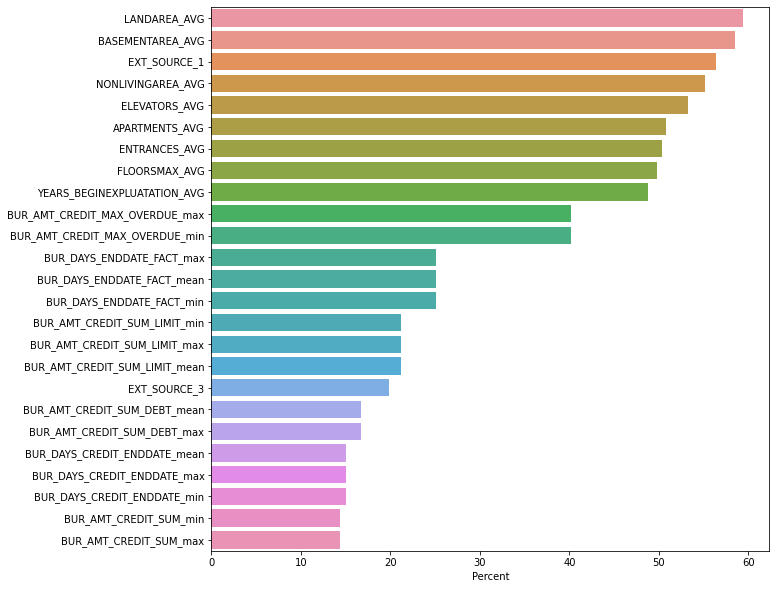

In [25]:
plt.figure(figsize=(10,10))
sns.barplot(y=missing_application_train_data.head(25).index, x=missing_application_train_data.head(25).Percent)

### Value Distribution in TARGET column

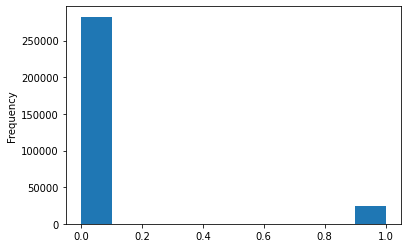

In [26]:
final_appTrainDF['TARGET'].astype(int).plot.hist();

In [27]:
# write out the new application training data
#final_appTrainDF.to_csv(DATA_DIR + '/train_clean.csv', index = False)

In [28]:
# write out the new application test data
#final_appTestDF.to_csv(DATA_DIR + '/test_clean.csv', index = False)

# Modeling

## Split

In [29]:
# assign the input and response features
X = final_appTrainDF.drop(['SK_ID_CURR', 'TARGET'], axis = 1) # features
y = final_appTrainDF['TARGET'] # label

In [30]:
#X.drop(['Unnamed: 0'],axis=1,inplace=True)

In [31]:
# split data such that 80% in training and 20% in test
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=42)

## Generate a smaller sample for tuning

In [32]:
# split data such that 10% is used for tuning, other 90% used for cross fold validation with best hyperparameters
x_sample_10, x_sample_90, y_sample_10, y_sample_90 = train_test_split(x_train, y_train, stratify=y_train, test_size=.9, random_state=42)

In [33]:
x_sample_10.shape

(24600, 745)

## Pipeline

In [34]:
'''numerical_features=[]
categorical_features =[]
categorical_features=categorical_features + final_appTrainDF.select_dtypes(include='object').columns.tolist()
numerical_features=numerical_features + final_appTrainDF.select_dtypes(exclude='object').columns.tolist()
numerical_features.remove('SK_ID_CURR')
numerical_features.remove('TARGET')'''


"numerical_features=[]\ncategorical_features =[]\ncategorical_features=categorical_features + final_appTrainDF.select_dtypes(include='object').columns.tolist()\nnumerical_features=numerical_features + final_appTrainDF.select_dtypes(exclude='object').columns.tolist()\nnumerical_features.remove('SK_ID_CURR')\nnumerical_features.remove('TARGET')"

### Set the data pipeline

In [35]:
'''# create pipeline for numeric features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# create pipeline for categorical features
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value="Unknown")),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

# specify the column transformer for numeric and categorical features
data_pipeline = ColumnTransformer(
    [("num_pipeline", num_pipeline, numerical_features),
    ("cat_pipeline", cat_pipeline, categorical_features)],
    remainder='passthrough')'''

'# create pipeline for numeric features\nnum_pipeline = Pipeline([\n        (\'imputer\', SimpleImputer(strategy="median")),\n        (\'std_scaler\', StandardScaler()),\n    ])\n\n# create pipeline for categorical features\ncat_pipeline = Pipeline([\n        (\'imputer\', SimpleImputer(strategy=\'constant\', fill_value="Unknown")),\n        (\'ohe\', OneHotEncoder(sparse=False, handle_unknown="ignore"))\n    ])\n\n# specify the column transformer for numeric and categorical features\ndata_pipeline = ColumnTransformer(\n    [("num_pipeline", num_pipeline, numerical_features),\n    ("cat_pipeline", cat_pipeline, categorical_features)],\n    remainder=\'passthrough\')'

In [36]:
columns = X.columns.tolist()
numerical_features=X.columns.tolist()[:-135]
categorical_features=X.columns.tolist()[-135:]
# create pipeline for numeric features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
# specify the column transformer for numeric features
data_pipeline = ColumnTransformer(
    [("num_pipeline", num_pipeline, numerical_features)],
    remainder='passthrough')

In [37]:
# test the transformer
'''X_train_transformed = data_pipeline.fit_transform(x_train)

column_names = numerical_features  + \
               list(data_pipeline.transformers_[1][1].named_steps["ohe"].get_feature_names(categorical_features))

display(pd.DataFrame(X_train_transformed,  columns=column_names).head())'''

'X_train_transformed = data_pipeline.fit_transform(x_train)\n\ncolumn_names = numerical_features  +                list(data_pipeline.transformers_[1][1].named_steps["ohe"].get_feature_names(categorical_features))\n\ndisplay(pd.DataFrame(X_train_transformed,  columns=column_names).head())'

In [38]:
X_train_transformed = data_pipeline.fit_transform(x_train)

column_names = numerical_features + categorical_features 

display(pd.DataFrame(X_train_transformed,  columns=column_names).head())

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREV_AMT_ANNUITY_min,PREV_AMT_ANNUITY_max,PREV_AMT_ANNUITY_mean,PREV_AMT_ANNUITY_count,PREV_AMT_ANNUITY_sum,PREV_AMT_APPLICATION_min,PREV_AMT_APPLICATION_max,PREV_AMT_APPLICATION_mean,PREV_AMT_DOWN_PAYMENT_min,PREV_AMT_DOWN_PAYMENT_max,PREV_AMT_DOWN_PAYMENT_count,PREV_AMT_GOODS_PRICE_min,PREV_HOUR_APPR_PROCESS_START_min,PREV_HOUR_APPR_PROCESS_START_max,PREV_HOUR_APPR_PROCESS_START_mean,PREV_NFLAG_LAST_APPL_IN_DAY_min,PREV_NFLAG_LAST_APPL_IN_DAY_max,PREV_NFLAG_LAST_APPL_IN_DAY_mean,PREV_RATE_DOWN_PAYMENT_min,PREV_RATE_DOWN_PAYMENT_max,PREV_RATE_DOWN_PAYMENT_mean,PREV_RATE_DOWN_PAYMENT_sum,PREV_RATE_INTEREST_PRIMARY_count,PREV_DAYS_DECISION_min,PREV_DAYS_DECISION_max,PREV_DAYS_DECISION_mean,PREV_DAYS_DECISION_sum,PREV_SELLERPLACE_AREA_min,PREV_SELLERPLACE_AREA_max,PREV_SELLERPLACE_AREA_mean,PREV_SELLERPLACE_AREA_sum,PREV_CNT_PAYMENT_min,PREV_CNT_PAYMENT_max,PREV_CNT_PAYMENT_mean,PREV_CNT_PAYMENT_sum,PREV_DAYS_FIRST_DRAWING_min,PREV_DAYS_FIRST_DRAWING_max,PREV_DAYS_FIRST_DRAWING_mean,PREV_DAYS_FIRST_DRAWING_count,PREV_DAYS_FIRST_DUE_max,PREV_DAYS_FIRST_DUE_mean,PREV_DAYS_LAST_DUE_1ST_VERSION_max,PREV_DAYS_LAST_DUE_1ST_VERSION_mean,PREV_DAYS_LAST_DUE_min,PREV_DAYS_LAST_DUE_max,PREV_DAYS_LAST_DUE_mean,PREV_DAYS_LAST_DUE_sum,PREV_NFLAG_INSURED_ON_APPROVAL_min,PREV_NFLAG_INSURED_ON_APPROVAL_max,PREV_NFLAG_INSURED_ON_APPROVAL_mean,PREV_NFLAG_INSURED_ON_APPROVAL_sum,PREV_POS_MONTHS_BALANCE_min_max,PREV_POS_MONTHS_BALANCE_min_mean,PREV_POS_MONTHS_BALANCE_count_min,PREV_POS_MONTHS_BALANCE_count_max,PREV_POS_MONTHS_BALANCE_count_mean,PREV_POS_MONTHS_BALANCE_count_sum,PREV_POS_MONTHS_BALANCE_sum_min,PREV_POS_MONTHS_BALANCE_sum_max,PREV_POS_MONTHS_BALANCE_sum_mean,PREV_POS_CNT_INSTALMENT_min_min,PREV_POS_CNT_INSTALMENT_min_max,PREV_POS_CNT_INSTALMENT_min_mean,PREV_POS_CNT_INSTALMENT_max_min,PREV_POS_CNT_INSTALMENT_max_max,PREV_POS_CNT_INSTALMENT_max_mean,PREV_POS_CNT_INSTALMENT_max_sum,PREV_POS_CNT_INSTALMENT_sum_min,PREV_POS_CNT_INSTALMENT_sum_max,PREV_POS_CNT_INSTALMENT_sum_mean,PREV_POS_CNT_INSTALMENT_sum_sum,PREV_POS_CNT_INSTALMENT_FUTURE_min_min,PREV_POS_CNT_INSTALMENT_FUTURE_min_max,PREV_POS_CNT_INSTALMENT_FUTURE_min_mean,PREV_POS_SK_DPD_min_max,PREV_POS_SK_DPD_min_mean,PREV_POS_SK_DPD_min_sum,PREV_POS_SK_DPD_max_min,PREV_POS_SK_DPD_max_max,PREV_POS_SK_DPD_DEF_min_max,PREV_POS_SK_DPD_DEF_min_mean,PREV_POS_SK_DPD_DEF_min_sum,PREV_POS_SK_DPD_DEF_max_min,PREV_POS_SK_DPD_DEF_max_max,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_max,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_mean,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_max,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_mean,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_mean_sum,PREV_POS_NAME_CONTRACT_STATUS_Amortized debt_sum_m

## Hyperparameter Tuning

### Candidate parameters

In [39]:
# set logistic parameter grid
logistic_params= {'logistic__C': (100, 10, 1, 0.1, 0.01),
                  'logistic__l1_ratio': (0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.),
                 }

# set random forest parameter grid
rf_params= {'rf__max_depth': range(6, 10),
            'rf__max_features': [1, 5, 10],
            'rf__min_samples_split': [5, 10, 15],
            'rf__min_samples_leaf': [3, 5, 10],
            'rf__n_estimators':[20, 80, 150, 200]
           }

# set xgboost parameter grid
xgb_params = {'xgb__n_estimators': [100, 200],
              'xgb__learning_rate': [0.01, 0.1],
              'xgb__max_depth': range(3, 10),
              'xgb__colsample_bytree': [i/10.0 for i in range(1, 3)]
             }

# set lightgbm parameter grid
lgbm_params = {'lgbm__n_estimators': [100, 300, 500],
              'lgbm__learning_rate': [0.01, 0.02, 0.1, 0.2],
              'lgbm__max_depth': range(3, 6, 9),
              'lgbm__colsample_bytree': [i/10.0 for i in range(1, 10)]
             }

## Logistic Regression - ZV

### Tuning

In [40]:
# generate the pipeline
from sklearn.feature_selection import VarianceThreshold

logistic_zv_pipeline = Pipeline([
("preparation", data_pipeline),
("zv", VarianceThreshold()),    
("logistic", LogisticRegression(penalty='elasticnet', solver='saga'))
])

# set up cross validation grid search
logistic_zv_grid_search = GridSearchCV(logistic_zv_pipeline,
                                    param_grid=logistic_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
logistic_zv_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   28.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  3.5min
[Parallel(n_jobs=20)]: Done 275 out of 275 | elapsed:  6.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [41]:
# print grid search results
pd.concat([pd.DataFrame(logistic_zv_grid_search.cv_results_["params"]),pd.DataFrame(logistic_zv_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,logistic__C,logistic__l1_ratio,roc_auc
46,0.01,0.2,0.753167
47,0.01,0.3,0.752737
45,0.01,0.1,0.751988
43,0.10,1.0,0.751887
42,0.10,0.9,0.751613
48,0.01,0.4,0.751253
41,0.10,0.8,0.751229
40,0.10,0.7,0.750835
39,0.10,0.6,0.750392
38,0.10,0.5,0.749840


In [42]:
# print the best parameters
logistic_zv_grid_search.best_params_

{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}

### Cross Validation Evalutation

In [43]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

results = cross_validate(logistic_zv_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=2)

In [44]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919064,0.759286
1,0.919448,0.765677
2,0.919064,0.757817
3,0.919379,0.764966
4,0.919130,0.755507


In [45]:
# calculate mean out of sample cv train roc score 
logistic_zv_train_mean_roc_score = np.mean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
logistic_zv_train_mean_roc_score

0.7606506101381079

In [46]:
# calculate mean out of sample cv train accuracy score 
logistic_zv_train_mean_accuracy_score = np.mean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
logistic_zv_train_mean_accuracy_score

0.9192170114656765

## Logistic Regression - PCA 0.95

### Tuning

In [47]:
# generate the pipeline
logistic_pca_pipeline = Pipeline([
("preparation", data_pipeline),
("pca", PCA(0.95)),    
("logistic", LogisticRegression(penalty='elasticnet', solver='saga'))
])

# set up cross validation grid search
logistic_pca_grid_search = GridSearchCV(logistic_pca_pipeline,
                                    param_grid=logistic_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
logistic_pca_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   22.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  2.6min
[Parallel(n_jobs=20)]: Done 275 out of 275 | elapsed:  4.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [48]:
# print grid search results
pd.concat([pd.DataFrame(logistic_pca_grid_search.cv_results_["params"]),pd.DataFrame(logistic_pca_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,logistic__C,logistic__l1_ratio,roc_auc
46,0.01,0.2,0.747587
45,0.01,0.1,0.747321
43,0.10,1.0,0.746611
42,0.10,0.9,0.746381
47,0.01,0.3,0.746303
41,0.10,0.8,0.746147
40,0.10,0.7,0.745929
39,0.10,0.6,0.745676
38,0.10,0.5,0.745458
44,0.01,0.0,0.745361


In [49]:
# print the best parameters
logistic_pca_grid_search.best_params_

{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}

### Cross Validation Evaluation

In [50]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

results = cross_validate(logistic_pca_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=2)

In [51]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919651,0.762065
1,0.919448,0.768043
2,0.919426,0.762491
3,0.919085,0.767337
4,0.919085,0.753818


In [52]:
# calculate mean out of sample cv train roc score 
logistic_pca_train_mean_roc_score = np.mean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
logistic_pca_train_mean_roc_score

0.7627506299996807

In [53]:
# calculate mean out of sample cv train accuracy score 
logistic_pca_train_mean_accuracy_score = np.mean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
logistic_pca_train_mean_accuracy_score

0.9193389556473045

## Logistic Regression

### Tuning

In [54]:
# generate the pipeline
logistic_pipeline = Pipeline([
("preparation", data_pipeline),
("logistic", LogisticRegression(penalty='elasticnet', solver='saga'))
])

# set up cross validation grid search
logistic_grid_search = GridSearchCV(logistic_pipeline,
                                    param_grid=logistic_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
logistic_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   28.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  3.7min
[Parallel(n_jobs=20)]: Done 275 out of 275 | elapsed:  6.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [55]:
# print grid search results
pd.concat([pd.DataFrame(logistic_grid_search.cv_results_["params"]),pd.DataFrame(logistic_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,logistic__C,logistic__l1_ratio,roc_auc
46,0.01,0.2,0.753186
47,0.01,0.3,0.752729
45,0.01,0.1,0.751996
43,0.10,1.0,0.751870
42,0.10,0.9,0.751570
48,0.01,0.4,0.751263
41,0.10,0.8,0.751252
40,0.10,0.7,0.750808
39,0.10,0.6,0.750399
38,0.10,0.5,0.749818


In [56]:
# print the best parameters
logistic_grid_search.best_params_

{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}

### Cross Validation Evalutation

In [57]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

results = cross_validate(logistic_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=2)

In [58]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919064,0.759296
1,0.919448,0.765677
2,0.919109,0.757821
3,0.919424,0.764962
4,0.919130,0.755496


In [59]:
# calculate mean out of sample cv train roc score 
logistic_train_mean_roc_score = np.mean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
logistic_train_mean_roc_score

0.7606505700149098

In [60]:
# calculate mean out of sample cv train accuracy score 
logistic_train_mean_accuracy_score = np.mean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
logistic_train_mean_accuracy_score

0.9192350777010141

## Logistic Regression - Feature Selection

In [61]:
test=SelectFromModel(LogisticRegression(penalty='l1'))

### Tuning

In [62]:
# generate the pipeline
logistic_fs_pipeline = Pipeline([
("preparation", data_pipeline),
("feature_selection", SelectFromModel(LogisticRegression(penalty='l2'))),
("logistic", LogisticRegression(penalty='elasticnet', solver='saga'))
])

# set up cross validation grid search
logistic_fs_grid_search = GridSearchCV(logistic_fs_pipeline,
                                    param_grid=logistic_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
logistic_fs_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   21.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  2.4min
[Parallel(n_jobs=20)]: Done 275 out of 275 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [63]:
# print grid search results
pd.concat([pd.DataFrame(logistic_fs_grid_search.cv_results_["params"]),pd.DataFrame(logistic_fs_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,logistic__C,logistic__l1_ratio,roc_auc
46,0.01,0.2,0.749400
47,0.01,0.3,0.748982
45,0.01,0.1,0.748829
43,0.10,1.0,0.748034
42,0.10,0.9,0.747890
48,0.01,0.4,0.747884
41,0.10,0.8,0.747705
40,0.10,0.7,0.747505
39,0.10,0.6,0.747261
38,0.10,0.5,0.747007


In [64]:
# print the best parameters
logistic_fs_grid_search.best_params_

{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}

### Cross Validation Evalutation

In [65]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

results = cross_validate(logistic_fs_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=2)

In [66]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919019,0.762679
1,0.919380,0.769874
2,0.919516,0.765780
3,0.919108,0.767810
4,0.919198,0.756699


In [67]:
# calculate mean out of sample cv train roc score 
logistic_fs_train_mean_roc_score = np.mean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
logistic_fs_train_mean_roc_score

0.7645682332871832

In [68]:
# calculate mean out of sample cv train accuracy score 
logistic_fs_train_mean_accuracy_score = np.mean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
logistic_fs_train_mean_accuracy_score

0.9192441095947247

# Light GBM -ZV

In [69]:
# generate the pipeline
lgbm_zv_pipeline = Pipeline([
    ("preparation", data_pipeline),
    ("zv", VarianceThreshold()), 
    ("lgbm", LGBMClassifier())
])

# set up cross validation grid search
lgbm_zv_grid_search = GridSearchCV(lgbm_zv_pipeline,
                                    param_grid=lgbm_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
lgbm_zv_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  3.5min
[Parallel(n_jobs=20)]: Done 540 out of 540 | elapsed:  5.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [70]:
# print grid search results
pd.concat([pd.DataFrame(lgbm_zv_grid_search.cv_results_["params"]),pd.DataFrame(lgbm_zv_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,lgbm__colsample_bytree,lgbm__learning_rate,lgbm__max_depth,lgbm__n_estimators,roc_auc
17,0.2,0.02,3,500,0.761217
65,0.6,0.02,3,500,0.759717
53,0.5,0.02,3,500,0.759672
41,0.4,0.02,3,500,0.759616
29,0.3,0.02,3,500,0.759406
7,0.1,0.10,3,300,0.759111
77,0.7,0.02,3,500,0.759089
89,0.8,0.02,3,500,0.758660
101,0.9,0.02,3,500,0.758560
5,0.1,0.02,3,500,0.757692


In [71]:
# print the best parameters
lgbm_zv_grid_search.best_params_

{'lgbm__colsample_bytree': 0.2,
 'lgbm__learning_rate': 0.02,
 'lgbm__max_depth': 3,
 'lgbm__n_estimators': 500}

#### Cross Validation Evaluation

In [72]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

#### Cross Validation Evaluation
results = cross_validate(lgbm_zv_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=3)

In [73]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919629,0.775195
1,0.919719,0.776592
2,0.919651,0.773527
3,0.919311,0.775757
4,0.919537,0.765403


In [74]:
# calculate mean out of sample cv train roc score 
lgbm_zv_train_mean_roc_score = np.nanmean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
lgbm_zv_train_mean_roc_score

0.7732947180065409

In [75]:
# calculate mean out of sample cv train accuracy score 
lgbm_zv_train_mean_accuracy_score = np.nanmean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
lgbm_zv_train_mean_accuracy_score

0.9195693006068433

# Light GBM - PCA 0.95

In [76]:
# generate the pipeline
lgbm_pca_pipeline = Pipeline([
    ("preparation", data_pipeline),
    ("pca", PCA(0.95)),  
    ("lgbm", LGBMClassifier())
])

# set up cross validation grid search
lgbm_pca_grid_search = GridSearchCV(lgbm_pca_pipeline,
                                    param_grid=lgbm_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
lgbm_pca_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   14.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  4.8min
[Parallel(n_jobs=20)]: Done 540 out of 540 | elapsed:  6.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [77]:
# print grid search results
pd.concat([pd.DataFrame(lgbm_pca_grid_search.cv_results_["params"]),pd.DataFrame(lgbm_pca_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,lgbm__colsample_bytree,lgbm__learning_rate,lgbm__max_depth,lgbm__n_estimators,roc_auc
5,0.1,0.02,3,500,0.722703
67,0.6,0.10,3,300,0.721838
29,0.3,0.02,3,500,0.721836
55,0.5,0.10,3,300,0.721126
7,0.1,0.10,3,300,0.720803
41,0.4,0.02,3,500,0.720451
17,0.2,0.02,3,500,0.719924
31,0.3,0.10,3,300,0.719841
65,0.6,0.02,3,500,0.719657
91,0.8,0.10,3,300,0.719597


In [78]:
# print the best parameters
lgbm_pca_grid_search.best_params_

{'lgbm__colsample_bytree': 0.1,
 'lgbm__learning_rate': 0.02,
 'lgbm__max_depth': 3,
 'lgbm__n_estimators': 500}

#### Cross Validation Evaluation

In [79]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

#### Cross Validation Evaluation
results = cross_validate(lgbm_pca_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=3)

In [80]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919267,0.736524
1,0.919267,0.738802
2,0.919267,0.737956
3,0.919288,0.742446
4,0.919266,0.729453


In [81]:
# calculate mean out of sample cv train roc score 
lgbm_pca_train_mean_roc_score = np.nanmean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
lgbm_pca_train_mean_roc_score

0.737036443853936

In [82]:
# calculate mean out of sample cv train accuracy score 
lgbm_pca_train_mean_accuracy_score = np.nanmean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
lgbm_pca_train_mean_accuracy_score

0.9192712097637032

# Light GBM - normal

In [83]:
# generate the pipeline
lgbm_pipeline = Pipeline([
    ("preparation", data_pipeline),
    ("lgbm", LGBMClassifier())
])

# set up cross validation grid search
lgbm_grid_search = GridSearchCV(lgbm_pipeline,
                                    param_grid=lgbm_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
lgbm_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  3.4min
[Parallel(n_jobs=20)]: Done 540 out of 540 | elapsed:  5.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [84]:
# print grid search results
pd.concat([pd.DataFrame(lgbm_grid_search.cv_results_["params"]),pd.DataFrame(lgbm_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,lgbm__colsample_bytree,lgbm__learning_rate,lgbm__max_depth,lgbm__n_estimators,roc_auc
17,0.2,0.02,3,500,0.761217
65,0.6,0.02,3,500,0.759717
53,0.5,0.02,3,500,0.759672
41,0.4,0.02,3,500,0.759616
29,0.3,0.02,3,500,0.759406
7,0.1,0.10,3,300,0.759111
77,0.7,0.02,3,500,0.759089
89,0.8,0.02,3,500,0.758660
101,0.9,0.02,3,500,0.758560
5,0.1,0.02,3,500,0.757692


In [85]:
# print the best parameters
lgbm_grid_search.best_params_

{'lgbm__colsample_bytree': 0.2,
 'lgbm__learning_rate': 0.02,
 'lgbm__max_depth': 3,
 'lgbm__n_estimators': 500}

#### Cross Validation Evaluation

In [86]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

#### Cross Validation Evaluation
results = cross_validate(lgbm_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=3)

In [87]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919629,0.775195
1,0.919719,0.776592
2,0.919651,0.773527
3,0.919311,0.775757
4,0.919537,0.765403


In [88]:
# calculate mean out of sample cv train roc score 
lgbm_train_mean_roc_score = np.nanmean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
lgbm_train_mean_roc_score

0.7732947180065409

In [89]:
# calculate mean out of sample cv train accuracy score 
lgbm_train_mean_accuracy_score = np.nanmean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
lgbm_train_mean_accuracy_score

0.9195693006068433

# Light GBM - Feature Selection

In [90]:
# generate the pipeline
lgbm_fs_pipeline = Pipeline([
    ("preparation", data_pipeline),
    ("feature_selection", SelectFromModel(LGBMClassifier(penalty='l2'))), 
    ("lgbm", LGBMClassifier())
])

# set up cross validation grid search
lgbm_fs_grid_search = GridSearchCV(lgbm_fs_pipeline,
                                    param_grid=lgbm_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
lgbm_fs_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   20.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  2.5min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  6.8min
[Parallel(n_jobs=20)]: Done 540 out of 540 | elapsed:  9.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [91]:
# print grid search results
pd.concat([pd.DataFrame(lgbm_fs_grid_search.cv_results_["params"]),pd.DataFrame(lgbm_fs_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,lgbm__colsample_bytree,lgbm__learning_rate,lgbm__max_depth,lgbm__n_estimators,roc_auc
29,0.3,0.02,3,500,0.759189
53,0.5,0.02,3,500,0.759038
41,0.4,0.02,3,500,0.758827
17,0.2,0.02,3,500,0.758200
77,0.7,0.02,3,500,0.757849
65,0.6,0.02,3,500,0.757757
89,0.8,0.02,3,500,0.757433
101,0.9,0.02,3,500,0.757406
42,0.4,0.10,3,100,0.756916
5,0.1,0.02,3,500,0.756777


In [92]:
# print the best parameters
lgbm_fs_grid_search.best_params_

{'lgbm__colsample_bytree': 0.3,
 'lgbm__learning_rate': 0.02,
 'lgbm__max_depth': 3,
 'lgbm__n_estimators': 500}

#### Cross Validation Evaluation

In [93]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

#### Cross Validation Evaluation
results = cross_validate(lgbm_fs_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=3)

In [94]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919493,0.774779
1,0.919809,0.776208
2,0.919651,0.773489
3,0.919401,0.775670
4,0.919491,0.766646


In [95]:
# calculate mean out of sample cv train roc score 
lgbm_fs_train_mean_roc_score = np.nanmean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
lgbm_fs_train_mean_roc_score

0.7733584199331631

In [96]:
# calculate mean out of sample cv train accuracy score 
lgbm_fs_train_mean_accuracy_score = np.nanmean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
lgbm_fs_train_mean_accuracy_score

0.9195693008108364

In [97]:
#xgstart

# XGBoost -ZV

In [98]:
# generate the pipeline
xgb_zv_pipeline = Pipeline([
    ("preparation", data_pipeline),
    ("zv", VarianceThreshold()), 
    ("xgb", XGBClassifier())
])

# set up cross validation grid search
xgb_zv_grid_search = GridSearchCV(xgb_zv_pipeline,
                                    param_grid=xgb_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
xgb_zv_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   17.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  3.4min
[Parallel(n_jobs=20)]: Done 280 out of 280 | elapsed:  7.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [99]:
# print grid search results
pd.concat([pd.DataFrame(xgb_zv_grid_search.cv_results_["params"]),pd.DataFrame(xgb_zv_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,xgb__colsample_bytree,xgb__learning_rate,xgb__max_depth,xgb__n_estimators,roc_auc
15,0.1,0.10,3,200,0.760392
43,0.2,0.10,3,200,0.758328
45,0.2,0.10,4,200,0.757868
44,0.2,0.10,4,100,0.756999
17,0.1,0.10,4,200,0.756378
42,0.2,0.10,3,100,0.755242
16,0.1,0.10,4,100,0.753351
14,0.1,0.10,3,100,0.752640
47,0.2,0.10,5,200,0.752569
46,0.2,0.10,5,100,0.752459


In [100]:
# print the best parameters
xgb_zv_grid_search.best_params_

{'xgb__colsample_bytree': 0.1,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 200}

#### Cross Validation Evaluation

In [101]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

#### Cross Validation Evaluation
results = cross_validate(xgb_zv_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=3)

In [102]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919629,0.780993
1,0.919606,0.780316
2,0.919719,0.779258
3,0.919288,0.782198
4,0.919740,0.771958


In [103]:
# calculate mean out of sample cv train roc score 
xgb_zv_train_mean_roc_score = np.nanmean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
xgb_zv_train_mean_roc_score

0.7789444487308155

In [104]:
# calculate mean out of sample cv train accuracy score 
xgb_zv_train_mean_accuracy_score = np.nanmean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
xgb_zv_train_mean_accuracy_score

0.9195964004698322

# XGBoost- PCA 0.95

In [105]:
# generate the pipeline
xgb_pca_pipeline = Pipeline([
    ("preparation", data_pipeline),
    ("pca", PCA(0.95)),  
    ("xgb", XGBClassifier())
])

# set up cross validation grid search
xgb_pca_grid_search = GridSearchCV(xgb_pca_pipeline,
                                    param_grid=xgb_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
xgb_pca_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   22.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  3.8min
[Parallel(n_jobs=20)]: Done 280 out of 280 | elapsed:  8.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [106]:
# print grid search results
pd.concat([pd.DataFrame(xgb_pca_grid_search.cv_results_["params"]),pd.DataFrame(xgb_pca_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,xgb__colsample_bytree,xgb__learning_rate,xgb__max_depth,xgb__n_estimators,roc_auc
43,0.2,0.10,3,200,0.720394
15,0.1,0.10,3,200,0.720317
45,0.2,0.10,4,200,0.717599
17,0.1,0.10,4,200,0.716048
44,0.2,0.10,4,100,0.715997
42,0.2,0.10,3,100,0.715269
16,0.1,0.10,4,100,0.714052
46,0.2,0.10,5,100,0.713138
47,0.2,0.10,5,200,0.710359
14,0.1,0.10,3,100,0.709805


In [107]:
# print the best parameters
xgb_pca_grid_search.best_params_

{'xgb__colsample_bytree': 0.2,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 200}

#### Cross Validation Evaluation

In [108]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

#### Cross Validation Evaluation
results = cross_validate(xgb_pca_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=3)

In [109]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919290,0.744761
1,0.919313,0.747397
2,0.919380,0.745259
3,0.919266,0.750643
4,0.919175,0.736938


In [110]:
# calculate mean out of sample cv train roc score 
xgb_pca_train_mean_roc_score = np.nanmean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
xgb_pca_train_mean_roc_score

0.7449997737332688

In [111]:
# calculate mean out of sample cv train accuracy score 
xgb_pca_train_mean_accuracy_score = np.nanmean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
xgb_pca_train_mean_accuracy_score

0.919284758777229

# XGBoost - normal

In [112]:
# generate the pipeline
xgb_pipeline = Pipeline([
    ("preparation", data_pipeline),
    ("xgb", XGBClassifier())
])

# set up cross validation grid search
xgb_grid_search = GridSearchCV(xgb_pipeline,
                                    param_grid=xgb_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
xgb_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   17.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  3.5min
[Parallel(n_jobs=20)]: Done 280 out of 280 | elapsed:  7.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [113]:
# print grid search results
pd.concat([pd.DataFrame(xgb_grid_search.cv_results_["params"]),pd.DataFrame(xgb_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,xgb__colsample_bytree,xgb__learning_rate,xgb__max_depth,xgb__n_estimators,roc_auc
43,0.2,0.10,3,200,0.760463
15,0.1,0.10,3,200,0.758466
42,0.2,0.10,3,100,0.758196
45,0.2,0.10,4,200,0.757474
44,0.2,0.10,4,100,0.757193
17,0.1,0.10,4,200,0.757153
46,0.2,0.10,5,100,0.754868
47,0.2,0.10,5,200,0.753471
16,0.1,0.10,4,100,0.752817
14,0.1,0.10,3,100,0.752087


In [114]:
# print the best parameters
xgb_grid_search.best_params_

{'xgb__colsample_bytree': 0.2,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 200}

#### Cross Validation Evaluation

In [115]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

#### Cross Validation Evaluation
results = cross_validate(xgb_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=3)

In [116]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919584,0.781363
1,0.920035,0.782296
2,0.919742,0.780538
3,0.919333,0.781782
4,0.919921,0.772958


In [117]:
# calculate mean out of sample cv train roc score 
xgb_train_mean_roc_score = np.nanmean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
xgb_train_mean_roc_score

0.7797874358505432

In [118]:
# calculate mean out of sample cv train accuracy score 
xgb_train_mean_accuracy_score = np.nanmean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
xgb_train_mean_accuracy_score

0.9197228637092094

# XGBoost - Feature Selection

In [119]:
# generate the pipeline
xgb_fs_pipeline = Pipeline([
    ("preparation", data_pipeline),
    ("feature_selection", SelectFromModel(XGBClassifier(penalty='l2'))), 
    ("xgb", XGBClassifier())
])

# set up cross validation grid search
xgb_fs_grid_search = GridSearchCV(xgb_fs_pipeline,
                                    param_grid=xgb_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=20,
                                    verbose=True)

# grid search on training data
xgb_fs_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   48.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  7.0min
[Parallel(n_jobs=20)]: Done 280 out of 280 | elapsed: 12.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [120]:
# print grid search results
pd.concat([pd.DataFrame(xgb_fs_grid_search.cv_results_["params"]),pd.DataFrame(xgb_fs_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,xgb__colsample_bytree,xgb__learning_rate,xgb__max_depth,xgb__n_estimators,roc_auc
43,0.2,0.10,3,200,0.759062
15,0.1,0.10,3,200,0.758335
44,0.2,0.10,4,100,0.757270
45,0.2,0.10,4,200,0.757219
42,0.2,0.10,3,100,0.757199
17,0.1,0.10,4,200,0.756709
46,0.2,0.10,5,100,0.754397
47,0.2,0.10,5,200,0.754065
16,0.1,0.10,4,100,0.753702
14,0.1,0.10,3,100,0.752362


In [121]:
# print the best parameters
xgb_fs_grid_search.best_params_

{'xgb__colsample_bytree': 0.2,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 200}

#### Cross Validation Evaluation

In [122]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

#### Cross Validation Evaluation
results = cross_validate(xgb_fs_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=3)

In [123]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results['test_accuracy'], 
     'test_roc_auc': results['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919696,0.782489
1,0.919855,0.781734
2,0.919606,0.779956
3,0.919627,0.782373
4,0.919627,0.772280


In [124]:
# calculate mean out of sample cv train roc score 
xgb_fs_train_mean_roc_score = np.nanmean(results['test_roc_auc'])

# print the mean out of sample cv train roc score
xgb_fs_train_mean_roc_score

0.7797663802059145

In [125]:
# calculate mean out of sample cv train accuracy score 
xgb_fs_train_mean_accuracy_score = np.nanmean(results['test_accuracy'])

# print the mean out of sample cv train accuracy score
xgb_fs_train_mean_accuracy_score

0.9196822151386842

# Model Evaluation

In [126]:
# initialize the test results data frame
results = pd.DataFrame(columns=['Model', 'Experiment', 'Train Accuracy', 'Test Accuracy', 'Train Area under ROC', 'Test Area under ROC', 'Best Parameters'])

## Regularized Logistic Regression w/ all Columns - ZV

In [127]:
# fit best estimator on entire training data
logistic_zv_clf = logistic_zv_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
logistic_zv_predictions = logistic_zv_clf.predict(x_test)

# calculate score on test predictions
logistic_zv_test_score = accuracy_score(y_test, logistic_zv_predictions)

# calculate roc_auc score on test predictions
logistic_zv_test_roc_score = roc_auc_score(y_test, logistic_zv_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
logistic_zv_test_classification_report = classification_report(y_test, logistic_zv_predictions)

# calculate confusion matrix on test predictions
logistic_zv_test_confusion_matrix = confusion_matrix(y_test, logistic_zv_predictions)

In [128]:
# display the classification report
print(logistic_zv_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.47      0.02      0.04      4965

    accuracy                           0.92     61503
   macro avg       0.70      0.51      0.50     61503
weighted avg       0.88      0.92      0.88     61503



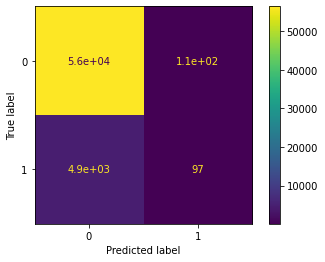

In [129]:
# plot confusion matrix
plot_confusion_matrix(logistic_zv_clf, x_test, y_test)
plt.show()

In [130]:
# add accuracy score to results table
results.loc[0] = ['Logistic Regression with ZV', 'Merged Datasets', np.round(logistic_zv_train_mean_accuracy_score*100, 2), np.round(logistic_zv_test_score*100, 2), 
                  np.round(logistic_zv_train_mean_roc_score*100, 2), np.round(logistic_zv_test_roc_score*100, 2), logistic_zv_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"


### Feature Importance

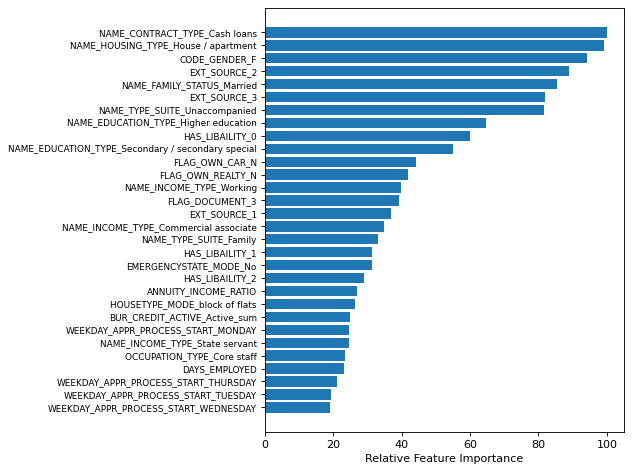

There are 58 features that have 0 importance.


In [131]:
# plot the feature importance
lr_feature_importance_plot(clf=logistic_zv_clf, names=column_names, n=30)

## Regularized Logistic Regression w/ all Columns - PCA 0.95

In [132]:
# fit best estimator on entire training data
logistic_pca_clf = logistic_pca_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
logistic_pca_predictions = logistic_pca_clf.predict(x_test)

# calculate score on test predictions
logistic_pca_test_score = accuracy_score(y_test, logistic_pca_predictions)

# calculate roc_auc score on test predictions
logistic_pca_test_roc_score = roc_auc_score(y_test, logistic_pca_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
logistic_pca_test_classification_report = classification_report(y_test, logistic_pca_predictions)

# calculate confusion matrix on test predictions
logistic_pca_test_confusion_matrix = confusion_matrix(y_test, logistic_pca_predictions)

In [133]:
# display the classification report
print(logistic_pca_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.55      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503



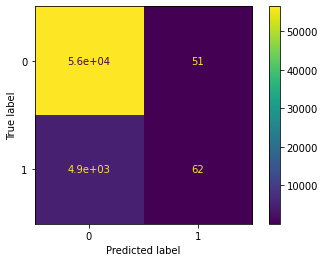

In [134]:
# plot confusion matrix
plot_confusion_matrix(logistic_pca_clf, x_test, y_test)
plt.show()

In [135]:
# add accuracy score to results table
results.loc[1] = ['Logistic Regression with PCA', 'Merged Datasets', np.round(logistic_pca_train_mean_accuracy_score*100, 2), np.round(logistic_pca_test_score*100, 2), 
                  np.round(logistic_pca_train_mean_roc_score*100, 2), np.round(logistic_pca_test_roc_score*100, 2), logistic_pca_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
1,Logistic Regression with PCA,Merged Datasets,91.93,91.95,76.28,76.59,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"


### Feature Importance

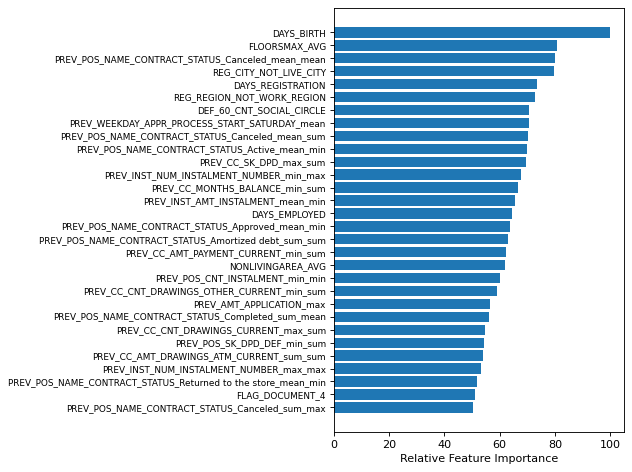

There are 1 features that have 0 importance.


In [136]:
# plot the feature importance
lr_feature_importance_plot(clf=logistic_pca_clf, names=column_names, n=30)

## Regularized Logistic Regression w/ all Columns

In [137]:
# fit best estimator on entire training data
logistic_clf = logistic_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
logistic_predictions = logistic_clf.predict(x_test)

# calculate score on test predictions
logistic_test_score = accuracy_score(y_test, logistic_predictions)

# calculate roc_auc score on test predictions
logistic_test_roc_score = roc_auc_score(y_test, logistic_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
logistic_test_classification_report = classification_report(y_test, logistic_predictions)

# calculate confusion matrix on test predictions
logistic_test_confusion_matrix = confusion_matrix(y_test, logistic_predictions)

In [138]:
# display the classification report
print(logistic_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.47      0.02      0.04      4965

    accuracy                           0.92     61503
   macro avg       0.70      0.51      0.50     61503
weighted avg       0.88      0.92      0.88     61503



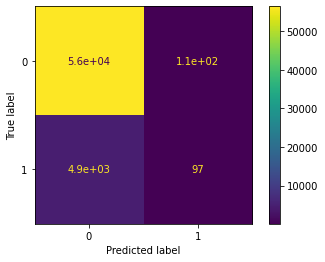

In [139]:
# plot confusion matrix
plot_confusion_matrix(logistic_clf, x_test, y_test)
plt.show()

In [140]:
# add accuracy score to results table
results.loc[2] = ['Logistic Regression', 'Merged Datasets', np.round(logistic_train_mean_accuracy_score*100, 2), np.round(logistic_test_score*100, 2), 
                  np.round(logistic_train_mean_roc_score*100, 2), np.round(logistic_test_roc_score*100, 2), logistic_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
1,Logistic Regression with PCA,Merged Datasets,91.93,91.95,76.28,76.59,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
2,Logistic Regression,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"


### Feature Importance

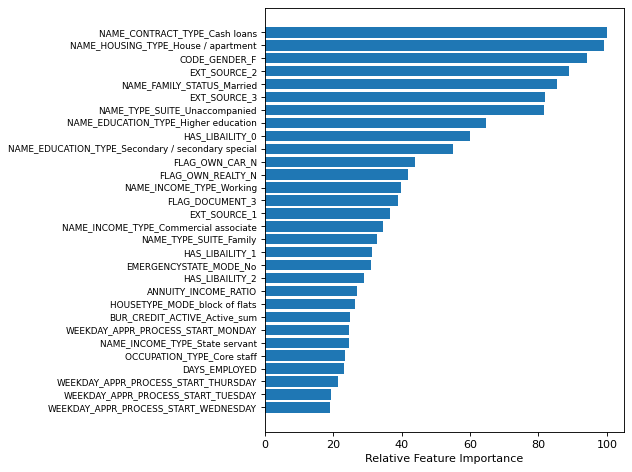

There are 59 features that have 0 importance.


In [141]:
# plot the feature importance
lr_feature_importance_plot(clf=logistic_clf, names=column_names, n=30)

## Regularized Logistic Regression w/ FS

In [142]:
# fit best estimator on entire training data
logistic_fs_clf = logistic_fs_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
logistic_fs_predictions = logistic_fs_clf.predict(x_test)

# calculate score on test predictions
logistic_fs_test_score = accuracy_score(y_test, logistic_fs_predictions)

# calculate roc_auc score on test predictions
logistic_fs_test_roc_score = roc_auc_score(y_test, logistic_fs_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
logistic_fs_test_classification_report = classification_report(y_test, logistic_fs_predictions)

# calculate confusion matrix on test predictions
logistic_fs_test_confusion_matrix = confusion_matrix(y_test, logistic_fs_predictions)

In [143]:
# display the classification report
print(logistic_fs_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.53      0.02      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



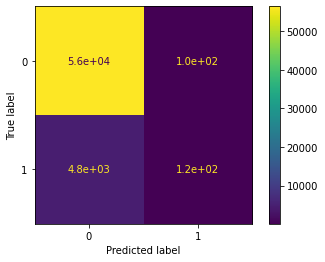

In [144]:
# plot confusion matrix
plot_confusion_matrix(logistic_fs_clf, x_test, y_test)
plt.show()

In [145]:
# add accuracy score to results table
results.loc[3] = ['Logistic Regression with FS', 'Merged Datasets', np.round(logistic_fs_train_mean_accuracy_score*100, 2), np.round(logistic_fs_test_score*100, 2), 
                  np.round(logistic_fs_train_mean_roc_score*100, 2), np.round(logistic_fs_test_roc_score*100, 2), logistic_fs_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
1,Logistic Regression with PCA,Merged Datasets,91.93,91.95,76.28,76.59,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
2,Logistic Regression,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
3,Logistic Regression with FS,Merged Datasets,91.92,91.95,76.46,76.69,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"


### Feature Importance

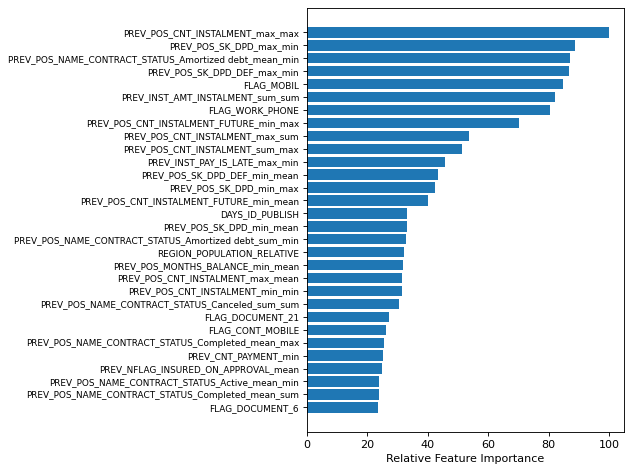

There are 29 features that have 0 importance.


In [146]:
# plot the feature importance
lr_feature_importance_plot(clf=logistic_fs_clf, names=column_names, n=30)

## Light GBM w/ all Columns - ZV

In [147]:
# fit best estimator on entire training data
lgbm_zv_clf = lgbm_zv_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
lgbm_zv_predictions = lgbm_zv_clf.predict(x_test)

# calculate score on test predictions
lgbm_zv_test_score = accuracy_score(y_test, lgbm_zv_predictions)

# calculate roc_auc score on test predictions
lgbm_zv_test_roc_score = roc_auc_score(y_test, lgbm_zv_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
lgbm_zv_test_classification_report = classification_report(y_test, logistic_zv_predictions)

# calculate confusion matrix on test predictions
lgbm_zv_test_confusion_matrix = confusion_matrix(y_test, logistic_zv_predictions)

In [148]:
# display the classification report
print(lgbm_zv_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.47      0.02      0.04      4965

    accuracy                           0.92     61503
   macro avg       0.70      0.51      0.50     61503
weighted avg       0.88      0.92      0.88     61503



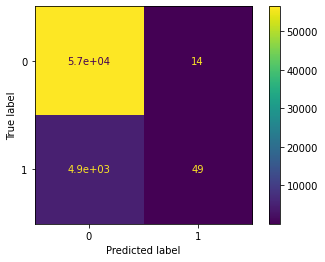

In [149]:
# plot confusion matrix
plot_confusion_matrix(lgbm_zv_clf, x_test, y_test)
plt.show()

In [150]:
# add accuracy score to results table
results.loc[4] = ['Light GBM with ZV', 'Merged Datasets', np.round(lgbm_zv_train_mean_accuracy_score*100, 2), np.round(lgbm_zv_test_score*100, 2), 
                  np.round(lgbm_zv_train_mean_roc_score*100, 2), np.round(lgbm_zv_test_roc_score*100, 2), lgbm_zv_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
1,Logistic Regression with PCA,Merged Datasets,91.93,91.95,76.28,76.59,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
2,Logistic Regression,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
3,Logistic Regression with FS,Merged Datasets,91.92,91.95,76.46,76.69,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
4,Light GBM with ZV,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."


### Feature Importance

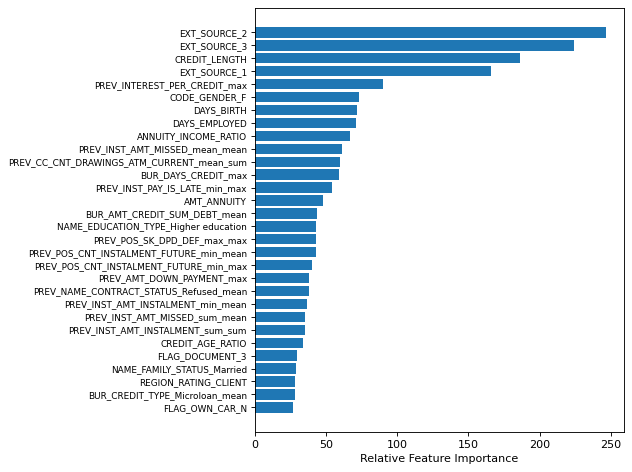

There are 458 features that have 0 importance.


In [151]:
# plot the feature importance
tree_feature_importance_plot(clf=lgbm_zv_clf, names=column_names,step_name='lgbm' ,n=30)

## Light GBM w/ all Columns - PCA 0.95

In [152]:
# fit best estimator on entire training data
lgbm_pca_clf = lgbm_pca_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
lgbm_pca_predictions = lgbm_pca_clf.predict(x_test)

# calculate score on test predictions
lgbm_pca_test_score = accuracy_score(y_test, lgbm_pca_predictions)

# calculate roc_auc score on test predictions
lgbm_pca_test_roc_score = roc_auc_score(y_test, lgbm_pca_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
lgbm_pca_test_classification_report = classification_report(y_test, lgbm_pca_predictions)

# calculate confusion matrix on test predictions
lgbm_pca_test_confusion_matrix = confusion_matrix(y_test, lgbm_pca_predictions)

In [153]:
# display the classification report
print(lgbm_pca_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



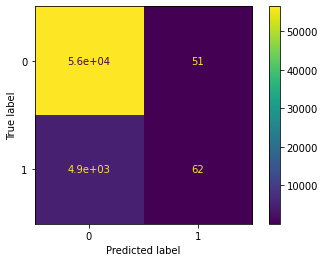

In [154]:
# plot confusion matrix
plot_confusion_matrix(logistic_pca_clf, x_test, y_test)
plt.show()

In [155]:
# add accuracy score to results table
results.loc[5] = ['Light GBM with PCA', 'Merged Datasets', np.round(lgbm_pca_train_mean_accuracy_score*100, 2), np.round(lgbm_pca_test_score*100, 2), 
                  np.round(lgbm_pca_train_mean_roc_score*100, 2), np.round(lgbm_pca_test_roc_score*100, 2), lgbm_pca_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
1,Logistic Regression with PCA,Merged Datasets,91.93,91.95,76.28,76.59,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
2,Logistic Regression,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
3,Logistic Regression with FS,Merged Datasets,91.92,91.95,76.46,76.69,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
4,Light GBM with ZV,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
5,Light GBM with PCA,Merged Datasets,91.93,91.93,73.70,74.01,"{'lgbm__colsample_bytree': 0.1, 'lgbm__learnin..."


### Feature Importance

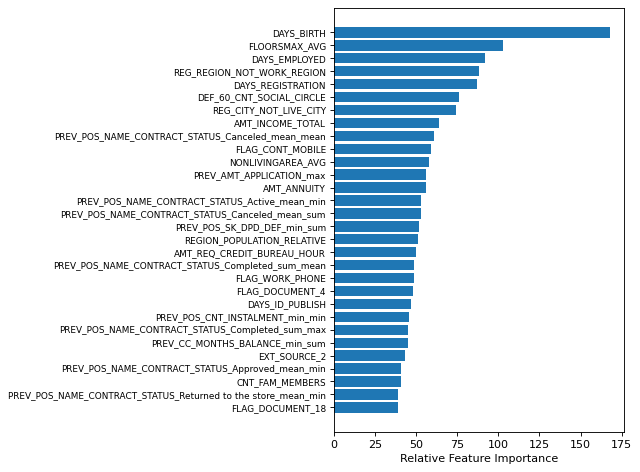

There are 86 features that have 0 importance.


In [156]:
# plot the feature importance
tree_feature_importance_plot(clf=lgbm_pca_clf, names=column_names,step_name='lgbm' ,n=30)

## Light GBM w/ all Columns

In [157]:

# fit best estimator on entire training data
lgbm_clf = lgbm_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
lgbm_predictions = lgbm_clf.predict(x_test)

# calculate score on test predictions
lgbm_test_score = accuracy_score(y_test, lgbm_predictions)

# calculate roc_auc score on test predictions
lgbm_test_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
lgbm_test_classification_report = classification_report(y_test, lgbm_predictions)

# calculate confusion matrix on test predictions
lgbm_test_confusion_matrix = confusion_matrix(y_test, lgbm_predictions)

In [158]:
# display the classification report
print(lgbm_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.78      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.85      0.50      0.49     61503
weighted avg       0.91      0.92      0.88     61503



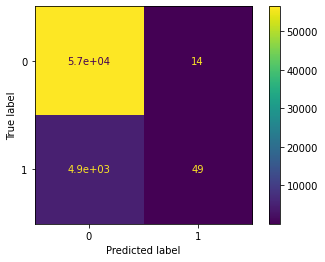

In [159]:
# plot confusion matrix
plot_confusion_matrix(lgbm_clf, x_test, y_test)
plt.show()

In [160]:
# add accuracy score to results table
results.loc[6] = ['Light GBM', 'Merged Datasets', np.round(lgbm_train_mean_accuracy_score*100, 2), np.round(lgbm_test_score*100, 2), 
                  np.round(lgbm_train_mean_roc_score*100, 2), np.round(lgbm_test_roc_score*100, 2), lgbm_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
1,Logistic Regression with PCA,Merged Datasets,91.93,91.95,76.28,76.59,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
2,Logistic Regression,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
3,Logistic Regression with FS,Merged Datasets,91.92,91.95,76.46,76.69,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
4,Light GBM with ZV,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
5,Light GBM with PCA,Merged Datasets,91.93,91.93,73.70,74.01,"{'lgbm__colsample_bytree': 0.1, 'lgbm__learnin..."
6,Light GBM,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."


### Feature Importance

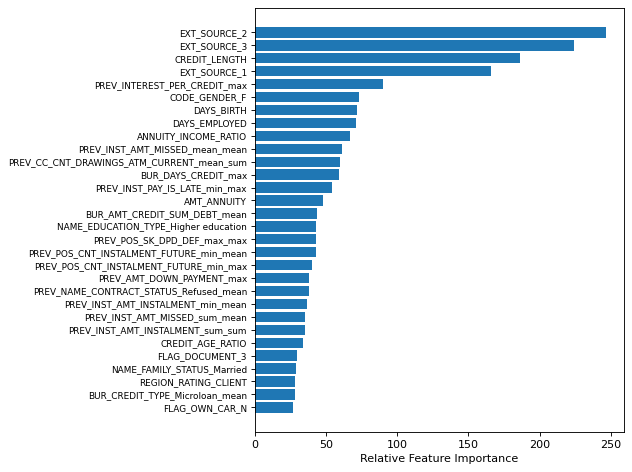

There are 458 features that have 0 importance.


In [161]:

# plot the feature importance
tree_feature_importance_plot(clf=lgbm_clf, names=column_names,step_name='lgbm' ,n=30)

## Light GBM Regression w/ FS

In [162]:
# fit best estimator on entire training data
lgbm_fs_clf = lgbm_fs_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
lgbm_fs_predictions = lgbm_fs_clf.predict(x_test)

# calculate score on test predictions
lgbm_fs_test_score = accuracy_score(y_test, lgbm_fs_predictions)

# calculate roc_auc score on test predictions
lgbm_fs_test_roc_score = roc_auc_score(y_test, lgbm_fs_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
lgbm_fs_test_classification_report = classification_report(y_test, lgbm_fs_predictions)

# calculate confusion matrix on test predictions
lgbm_fs_test_confusion_matrix = confusion_matrix(y_test, lgbm_fs_predictions)

In [163]:
# display the classification report
print(lgbm_fs_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.78      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.85      0.51      0.49     61503
weighted avg       0.91      0.92      0.88     61503



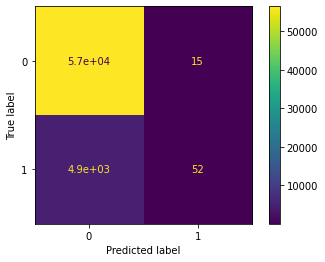

In [164]:
# plot confusion matrix
plot_confusion_matrix(lgbm_fs_clf, x_test, y_test)
plt.show()

In [165]:
# add accuracy score to results table
results.loc[7] = ['Light GBM with FS', 'Merged Datasets', np.round(lgbm_fs_train_mean_accuracy_score*100, 2), np.round(lgbm_fs_test_score*100, 2), 
                  np.round(lgbm_fs_train_mean_roc_score*100, 2), np.round(lgbm_fs_test_roc_score*100, 2), lgbm_fs_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
1,Logistic Regression with PCA,Merged Datasets,91.93,91.95,76.28,76.59,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
2,Logistic Regression,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
3,Logistic Regression with FS,Merged Datasets,91.92,91.95,76.46,76.69,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
4,Light GBM with ZV,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
5,Light GBM with PCA,Merged Datasets,91.93,91.93,73.70,74.01,"{'lgbm__colsample_bytree': 0.1, 'lgbm__learnin..."
6,Light GBM,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
7,Light GBM with FS,Merged Datasets,91.96,91.99,77.34,77.70,"{'lgbm__colsample_bytree': 0.3, 'lgbm__learnin..."


### Feature Importance

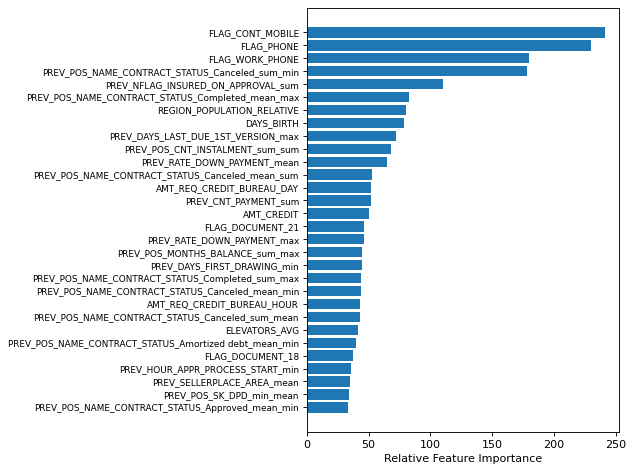

There are 11 features that have 0 importance.


In [166]:
# plot the feature importance
tree_feature_importance_plot(clf=lgbm_fs_clf, names=column_names,step_name='lgbm' ,n=30)

## XGBoost w/ all Columns - ZV

In [167]:
# fit best estimator on entire training data
xgb_zv_clf = xgb_zv_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
xgb_zv_predictions = xgb_zv_clf.predict(x_test)

# calculate score on test predictions
xgb_zv_test_score = accuracy_score(y_test, xgb_zv_predictions)

# calculate roc_auc score on test predictions
xgb_zv_test_roc_score = roc_auc_score(y_test, xgb_zv_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
xgb_zv_test_classification_report = classification_report(y_test, logistic_zv_predictions)

# calculate confusion matrix on test predictions
xgb_zv_test_confusion_matrix = confusion_matrix(y_test, logistic_zv_predictions)

In [168]:
# display the classification report
print(xgb_zv_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.47      0.02      0.04      4965

    accuracy                           0.92     61503
   macro avg       0.70      0.51      0.50     61503
weighted avg       0.88      0.92      0.88     61503



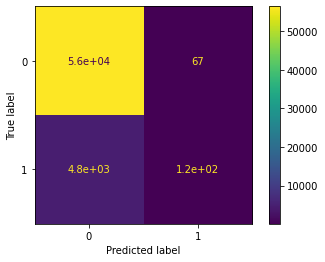

In [169]:
# plot confusion matrix
plot_confusion_matrix(xgb_zv_clf, x_test, y_test)
plt.show()

In [170]:
# add accuracy score to results table
results.loc[8] = ['XGBoost with ZV', 'Merged Datasets', np.round(xgb_zv_train_mean_accuracy_score*100, 2), np.round(xgb_zv_test_score*100, 2), 
                  np.round(xgb_zv_train_mean_roc_score*100, 2), np.round(xgb_zv_test_roc_score*100, 2), xgb_zv_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
1,Logistic Regression with PCA,Merged Datasets,91.93,91.95,76.28,76.59,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
2,Logistic Regression,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
3,Logistic Regression with FS,Merged Datasets,91.92,91.95,76.46,76.69,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
4,Light GBM with ZV,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
5,Light GBM with PCA,Merged Datasets,91.93,91.93,73.70,74.01,"{'lgbm__colsample_bytree': 0.1, 'lgbm__learnin..."
6,Light GBM,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
7,Light GBM with FS,Merged Datasets,91.96,91.99,77.34,77.70,"{'lgbm__colsample_bytree': 0.3, 'lgbm__learnin..."
8,XGBoost with ZV,Merged Datasets,91.96,92.01,77.89,78.47,"{'xgb__colsample_bytree': 0.1, 'xgb__learning_..."


### Feature Importance

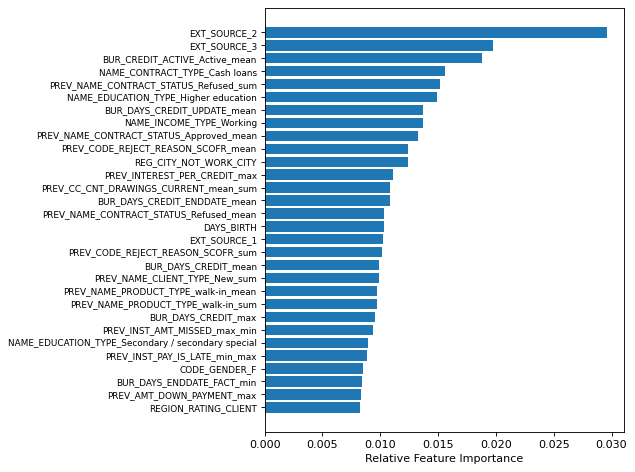

There are 472 features that have 0 importance.


In [171]:
# plot the feature importance
tree_feature_importance_plot(clf=xgb_zv_clf, names=column_names,step_name='xgb' ,n=30)

## XGBoost w/ all Columns - PCA 0.95

In [172]:
# fit best estimator on entire training data
xgb_pca_clf = xgb_pca_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
xgb_pca_predictions = xgb_pca_clf.predict(x_test)

# calculate score on test predictions
xgb_pca_test_score = accuracy_score(y_test, xgb_pca_predictions)

# calculate roc_auc score on test predictions
xgb_pca_test_roc_score = roc_auc_score(y_test, xgb_pca_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
xgb_pca_test_classification_report = classification_report(y_test, xgb_pca_predictions)

# calculate confusion matrix on test predictions
xgb_pca_test_confusion_matrix = confusion_matrix(y_test, xgb_pca_predictions)

In [173]:
# display the classification report
print(xgb_pca_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.64      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.78      0.50      0.48     61503
weighted avg       0.90      0.92      0.88     61503



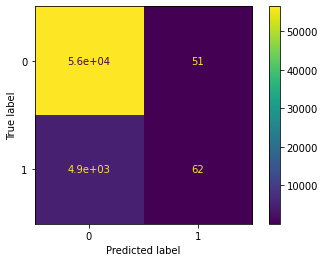

In [174]:
# plot confusion matrix
plot_confusion_matrix(logistic_pca_clf, x_test, y_test)
plt.show()

In [175]:
# add accuracy score to results table
results.loc[9] = ['XGBoost with PCA', 'Merged Datasets', np.round(xgb_pca_train_mean_accuracy_score*100, 2), np.round(xgb_pca_test_score*100, 2), 
                  np.round(xgb_pca_train_mean_roc_score*100, 2), np.round(xgb_pca_test_roc_score*100, 2), xgb_pca_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
1,Logistic Regression with PCA,Merged Datasets,91.93,91.95,76.28,76.59,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
2,Logistic Regression,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
3,Logistic Regression with FS,Merged Datasets,91.92,91.95,76.46,76.69,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
4,Light GBM with ZV,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
5,Light GBM with PCA,Merged Datasets,91.93,91.93,73.70,74.01,"{'lgbm__colsample_bytree': 0.1, 'lgbm__learnin..."
6,Light GBM,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
7,Light GBM with FS,Merged Datasets,91.96,91.99,77.34,77.70,"{'lgbm__colsample_bytree': 0.3, 'lgbm__learnin..."
8,XGBoost with ZV,Merged Datasets,91.96,92.01,77.89,78.47,"{'xgb__colsample_bytree': 0.1, 'xgb__learning_..."
9,XGBoost with PCA,Merged Datasets,91.93,91.93,74.50,74.82,"{'xgb__colsample_bytree': 0.2, 'xgb__learning_..."


### Feature Importance

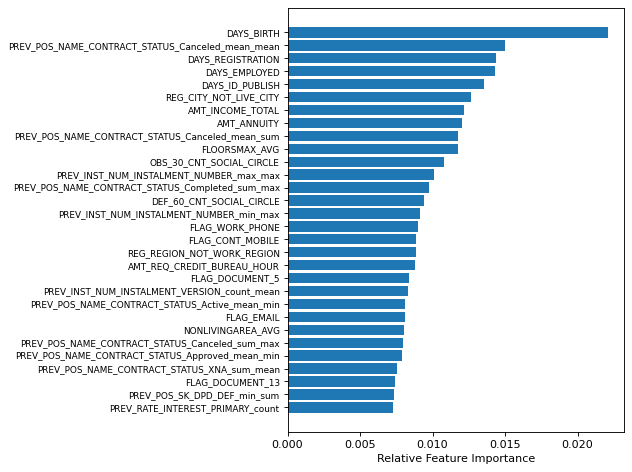

There are 122 features that have 0 importance.


In [176]:
# plot the feature importance
tree_feature_importance_plot(clf=xgb_pca_clf, names=column_names,step_name='xgb' ,n=30)

## XGBoost w/ all Columns

In [177]:

# fit best estimator on entire training data
xgb_clf = xgb_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
xgb_predictions = xgb_clf.predict(x_test)

# calculate score on test predictions
xgb_test_score = accuracy_score(y_test, xgb_predictions)

# calculate roc_auc score on test predictions
xgb_test_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
xgb_test_classification_report = classification_report(y_test, xgb_predictions)

# calculate confusion matrix on test predictions
xgb_test_confusion_matrix = confusion_matrix(y_test, xgb_predictions)

In [178]:
# display the classification report
print(xgb_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.63      0.02      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.78      0.51      0.50     61503
weighted avg       0.90      0.92      0.88     61503



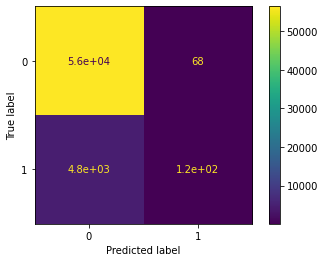

In [179]:
# plot confusion matrix
plot_confusion_matrix(xgb_clf, x_test, y_test)
plt.show()

In [180]:
# add accuracy score to results table
results.loc[10] = ['XGBoost', 'Merged Datasets', np.round(xgb_train_mean_accuracy_score*100, 2), np.round(xgb_test_score*100, 2), 
                  np.round(xgb_train_mean_roc_score*100, 2), np.round(xgb_test_roc_score*100, 2), xgb_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
1,Logistic Regression with PCA,Merged Datasets,91.93,91.95,76.28,76.59,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
2,Logistic Regression,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
3,Logistic Regression with FS,Merged Datasets,91.92,91.95,76.46,76.69,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
4,Light GBM with ZV,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
5,Light GBM with PCA,Merged Datasets,91.93,91.93,73.70,74.01,"{'lgbm__colsample_bytree': 0.1, 'lgbm__learnin..."
6,Light GBM,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
7,Light GBM with FS,Merged Datasets,91.96,91.99,77.34,77.70,"{'lgbm__colsample_bytree': 0.3, 'lgbm__learnin..."
8,XGBoost with ZV,Merged Datasets,91.96,92.01,77.89,78.47,"{'xgb__colsample_bytree': 0.1, 'xgb__learning_..."
9,XGBoost with PCA,Merged Datasets,91.93,91.93,74.50,74.82,"{'xgb__colsample_bytree': 0.2, 'xgb__learning_..."


### Feature Importance

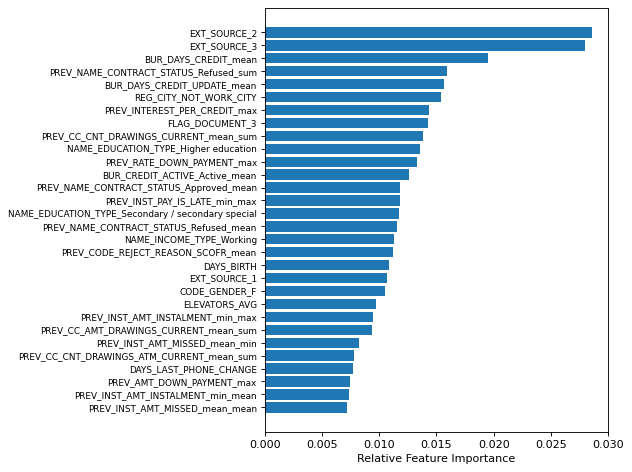

There are 480 features that have 0 importance.


In [181]:

# plot the feature importance
tree_feature_importance_plot(clf=xgb_clf, names=column_names,step_name='xgb' ,n=30)

## XGBoost Regression w/ FS

In [182]:
# fit best estimator on entire training data
xgb_fs_clf = xgb_fs_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
xgb_fs_predictions = xgb_fs_clf.predict(x_test)

# calculate score on test predictions
xgb_fs_test_score = accuracy_score(y_test, xgb_fs_predictions)

# calculate roc_auc score on test predictions
xgb_fs_test_roc_score = roc_auc_score(y_test, xgb_fs_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
xgb_fs_test_classification_report = classification_report(y_test, xgb_fs_predictions)

# calculate confusion matrix on test predictions
xgb_fs_test_confusion_matrix = confusion_matrix(y_test, xgb_fs_predictions)

In [183]:
# display the classification report
print(xgb_fs_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.59      0.03      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.76      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



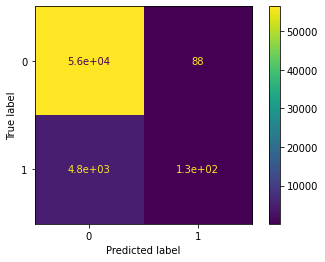

In [184]:
# plot confusion matrix
plot_confusion_matrix(xgb_fs_clf, x_test, y_test)
plt.show()

In [185]:
# add accuracy score to results table
results.loc[11] = ['XGBoost with FS', 'Merged Datasets', np.round(xgb_fs_train_mean_accuracy_score*100, 2), np.round(xgb_fs_test_score*100, 2), 
                  np.round(xgb_fs_train_mean_roc_score*100, 2), np.round(xgb_fs_test_roc_score*100, 2), xgb_fs_grid_search.best_params_]

# show results
results

,Model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression with ZV,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
1,Logistic Regression with PCA,Merged Datasets,91.93,91.95,76.28,76.59,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
2,Logistic Regression,Merged Datasets,91.92,91.91,76.07,76.36,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
3,Logistic Regression with FS,Merged Datasets,91.92,91.95,76.46,76.69,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.2}"
4,Light GBM with ZV,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
5,Light GBM with PCA,Merged Datasets,91.93,91.93,73.70,74.01,"{'lgbm__colsample_bytree': 0.1, 'lgbm__learnin..."
6,Light GBM,Merged Datasets,91.96,91.98,77.33,77.71,"{'lgbm__colsample_bytree': 0.2, 'lgbm__learnin..."
7,Light GBM with FS,Merged Datasets,91.96,91.99,77.34,77.70,"{'lgbm__colsample_bytree': 0.3, 'lgbm__learnin..."
8,XGBoost with ZV,Merged Datasets,91.96,92.01,77.89,78.47,"{'xgb__colsample_bytree': 0.1, 'xgb__learning_..."
9,XGBoost with PCA,Merged Datasets,91.93,91.93,74.50,74.82,"{'xgb__colsample_bytree': 0.2, 'xgb__learning_..."


### Feature Importance

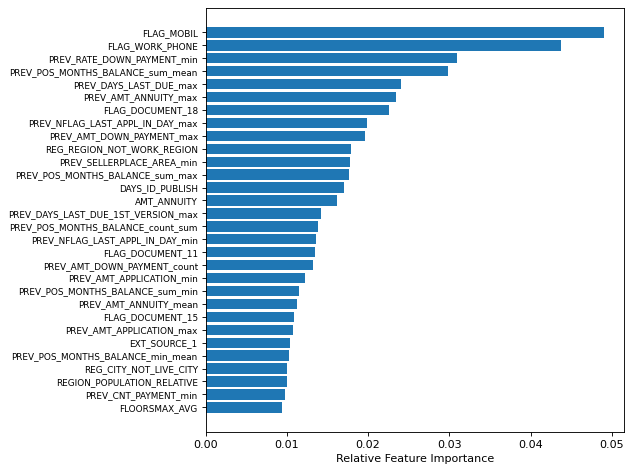

There are 3 features that have 0 importance.


In [186]:
# plot the feature importance
tree_feature_importance_plot(clf=xgb_fs_clf, names=column_names,step_name='xgb' ,n=30)

# Time Tracker - To Be Deleted

In [187]:
# temp time check - remove before submission
print("Start time is ", begin_time)
print("End time is ", datetime.datetime.now())
print("Run time is ", datetime.datetime.now() - begin_time)

Start time is  2021-04-23 05:12:34.610162
End time is  2021-04-23 08:58:02.214508
Run time is  3:45:27.604419
